<center><h1>Anne_Sai Venkata Naga Saketh_Final Project</h1></center>

Name: Anne Sai Venkata Naga Saketh
<br>
Github Username: sakethanne
<br>
USC ID: 3725520208

#### Import packages

In [21]:
# Importing necessary libraries
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import random

import numpy as np
from tqdm import tqdm
from skimage import io
import cv2
from PIL import Image

# Importing TensorFlow for deep learning tasks
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing metrics for model evaluation
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Importing pre-trained models for transfer learning
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

### (a) In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost. You can find the dataset in https://dataverse.jpl. nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA. This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate.

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 16

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

### (b) Data Exploration and Pre-processing

#### (i)

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

#### (ii)

In [4]:
def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True) 

In [5]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

### (c) Training CNN + MLP

#### (i) Augment the Image Dataset

In [7]:
# Function to convert label to one-hot encoding
def o_h_encoding(image, label):
    # Convert the label to one-hot encoding, with a depth of 2
    label = tf.one_hot(label, depth=2)
    # Return the image and the label
    return image, label

# Apply one-hot encoding to training, validation, and test datasets
tf_dataset_train_onehot = tf_dataset_train.map(o_h_encoding)
tf_dataset_val_onehot = tf_dataset_val.map(o_h_encoding)
tf_dataset_test_onehot = tf_dataset_test.map(o_h_encoding)

# Function to augment data with random transformations
def augment_images(image, label):
    # Apply random transformations using tf.image functions

    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    
    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    
    # Apply random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Apply random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Randomly rotate the image by 90, 180, or 270 degrees
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Randomly crop the image to the specified size
    image = tf.image.random_crop(image, size=(32, 299, 299, 3))
    
    # Randomly pad the image to simulate translation
    image = tf.image.pad_to_bounding_box(image, offset_height=20, offset_width=20, target_height=IMAGE_SIZE[0] + 40, target_width=IMAGE_SIZE[1] + 40)
    
    # Randomly zoom the image
    scale = tf.random.uniform([], 0.8, 1.2)
    h, w = IMAGE_SIZE[0], IMAGE_SIZE[1]
    new_height, new_width = h * scale, w * scale
    image = tf.image.resize(image, [int(new_height), int(new_width)])
    image = tf.image.resize_with_crop_or_pad(image, h, w)
    
    # one-hot encode the label as well
    # label = tf.one_hot(label, depth=2)

    return image, label

# Take one batch for demonstration
for img, label in tf_dataset_train_onehot.take(1):
    # Convert the image and label tensors to NumPy arrays and print
    print(img.numpy())
    print(label.numpy())

[[[[0.5764706  0.5764706  0.5764706 ]
   [0.5882353  0.5882353  0.5882353 ]
   [0.654902   0.654902   0.654902  ]
   ...
   [0.47058824 0.47058824 0.47058824]
   [0.49803922 0.49803922 0.49803922]
   [0.5411765  0.5411765  0.5411765 ]]

  [[0.4745098  0.4745098  0.4745098 ]
   [0.49019608 0.49019608 0.49019608]
   [0.6117647  0.6117647  0.6117647 ]
   ...
   [0.47843137 0.47843137 0.47843137]
   [0.5019608  0.5019608  0.5019608 ]
   [0.53333336 0.53333336 0.53333336]]

  [[0.32941177 0.32941177 0.32941177]
   [0.38431373 0.38431373 0.38431373]
   [0.5529412  0.5529412  0.5529412 ]
   ...
   [0.5058824  0.5058824  0.5058824 ]
   [0.54509807 0.54509807 0.54509807]
   [0.54901963 0.54901963 0.54901963]]

  ...

  [[0.74509805 0.74509805 0.74509805]
   [0.78039217 0.78039217 0.78039217]
   [0.78431374 0.78431374 0.78431374]
   ...
   [0.5294118  0.5294118  0.5294118 ]
   [0.5647059  0.5647059  0.5647059 ]
   [0.5568628  0.5568628  0.5568628 ]]

  [[0.78431374 0.78431374 0.78431374]
   [0.7

In [8]:
# Apply data augmentation to the one-hot encoded training dataset
tf_dataset_train_onehot_aug = tf_dataset_train_onehot.map(augment_images)

# Combine the original one-hot encoded training dataset with the augmented dataset
tf_dataset_train_combined = tf_dataset_train_onehot.concatenate(tf_dataset_train_onehot_aug)

# Shuffle the combined training dataset to introduce randomness during training
tf_dataset_train_combined = tf_dataset_train_combined.shuffle(buffer_size=buffer_size)

#### (ii)

In [9]:
# Define the number of classes in the classification task
num_classes = 2

# Define a convolutional neural network with 3 convolutional layers
def conv_neu_network_3_layers():
    # Create a Sequential model
    model = tf.keras.models.Sequential([
        # First convolutional layer with 16 filters, 3x3 kernel, 'same' padding, and ReLU activation
        layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(299, 299, 3)),
        
        # Batch normalization to normalize and stabilize activations
        layers.BatchNormalization(),
        
        # Max pooling layer to downsample the spatial dimensions
        layers.MaxPooling2D((2,2)),
        
        # Second convolutional layer with 32 filters, 3x3 kernel, 'same' padding, and ReLU activation
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        
        # Batch normalization
        layers.BatchNormalization(),
        
        # Max pooling layer
        layers.MaxPooling2D((2,2)),
        
        # Third convolutional layer with 64 filters, 3x3 kernel, 'same' padding, and ReLU activation
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        
        # Batch normalization
        layers.BatchNormalization(),
        
        # Max pooling layer
        layers.MaxPooling2D((2,2)),
        
        # Flatten layer to convert 3D output to 1D for the fully connected layers
        layers.Flatten(),
        
        # Fully connected layer with 128 units, ReLU activation, and L2 regularization
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        
        # Dropout layer with a dropout rate of 30% to prevent overfitting
        layers.Dropout(0.3),
        
        # Output layer with 'num_classes' units and softmax activation for classification
        layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])
    
    # Return the defined model
    return model

In [10]:
# Define the number of training epochs
epochs = 20

# Create a convolutional neural network model with 3 convolutional layers
model = conv_neu_network_3_layers()

# Compile the model with specified optimizer, loss function, and metrics
model.compile(
    # Adam optimizer, an efficient optimization algorithm
    optimizer='adam',  
    # Categorical Crossentropy loss for multi-class classification
    loss=tf.keras.losses.CategoricalCrossentropy(),  
    # Monitor accuracy during training
    metrics=['accuracy']  
)

# Display a summary of the model architecture, including layer names, output shapes, and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 299, 299, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 149, 149, 32)      128       
 chNormalization)                                                
                                                        

In [11]:
# Early stopping callback to stop training if the validation loss does not improve for a certain number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    # Monitor the validation loss
    monitor='val_loss',
    # Number of epochs with no improvement after which training will be stopped
    patience=3,
    # Display messages about the early stopping process
    verbose=1,
    # Restore model weights from the epoch with the best value of the monitored quantit
    restore_best_weights=True)

# Initial early stopping callback (Note: This seems to be a duplicate, as it has the same configuration as es_callback)
initial_run = tf.keras.callbacks.EarlyStopping(
    # Monitor the validation loss
    monitor='val_loss',
    # Number of epochs with no improvement after which training will be stopped
    patience=20,
    # Display messages about the early stopping process
    verbose=1,
    # Restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=True)

In [12]:
# Run the model using the un-augmented dataset
history = model.fit(tf_dataset_train_onehot,validation_data=tf_dataset_val_onehot,epochs=5,callbacks=[early_stopping])

Epoch 1/5
441/441 [==============================] - 356s 806ms/step - loss: 3.2083 - accuracy: 0.8656 - val_loss: 1.1010 - val_accuracy: 0.8863
Epoch 2/5
441/441 [==============================] - 351s 796ms/step - loss: 0.5308 - accuracy: 0.8880 - val_loss: 0.8202 - val_accuracy: 0.7276
Epoch 3/5
441/441 [==============================] - 363s 823ms/step - loss: 0.3425 - accuracy: 0.9204 - val_loss: 0.7057 - val_accuracy: 0.7624
Epoch 4/5
441/441 [==============================] - 342s 774ms/step - loss: 0.3194 - accuracy: 0.9229 - val_loss: 3.4412 - val_accuracy: 0.3081
Epoch 5/5
441/441 [==============================] - 319s 724ms/step - loss: 0.2768 - accuracy: 0.9302 - val_loss: 0.5716 - val_accuracy: 0.8228


In [13]:
# Create a convolutional neural network model with 3 convolutional layers
model_aug = conv_neu_network_3_layers()

# Compile the model with specified optimizer, loss function, and metrics, using Categorical Crossentropy loss for multi-class classification
model_aug.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Display a summary of the model architecture, including layer names, output shapes, and parameters
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 299, 299, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 299, 299, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 149, 149, 32)      4640      
                                                                 
 batch_normalization_4 (Bat  (None, 149, 149, 32)      128       
 chNormalization)                                                
                                                      

In [14]:
# Run the model using the augmented images dataset
history_augmented_initial_run = model_aug.fit(tf_dataset_train_combined,validation_data=tf_dataset_val_onehot,epochs=epochs,callbacks = [initial_run])

Epoch 1/20
882/882 [==============================] - 659s 745ms/step - loss: 1.9066 - accuracy: 0.7911 - val_loss: 1.0010 - val_accuracy: 0.3721
Epoch 2/20
882/882 [==============================] - 559s 632ms/step - loss: 0.6442 - accuracy: 0.8223 - val_loss: 0.8260 - val_accuracy: 0.8195
Epoch 3/20
882/882 [==============================] - 569s 643ms/step - loss: 0.4301 - accuracy: 0.8726 - val_loss: 0.3941 - val_accuracy: 0.9521
Epoch 4/20
882/882 [==============================] - 563s 636ms/step - loss: 0.5422 - accuracy: 0.8711 - val_loss: 0.7640 - val_accuracy: 0.8986
Epoch 5/20
882/882 [==============================] - 560s 634ms/step - loss: 0.4549 - accuracy: 0.8819 - val_loss: 0.5619 - val_accuracy: 0.7665
Epoch 6/20
882/882 [==============================] - 575s 650ms/step - loss: 0.3429 - accuracy: 0.9132 - val_loss: 21.2793 - val_accuracy: 0.2311
Epoch 7/20
882/882 [==============================] - 601s 680ms/step - loss: 0.3350 - accuracy: 0.9214 - val_loss: 8.1887 

In [15]:
# Run the model using the augmented images dataset using early stopping callbacks
history_augmented = model_aug.fit(tf_dataset_train_combined,validation_data=tf_dataset_val_onehot,epochs=epochs,callbacks = [early_stopping])

Epoch 1/20
882/882 [==============================] - 630s 713ms/step - loss: 0.2625 - accuracy: 0.9822 - val_loss: 2.9709 - val_accuracy: 0.6610
Epoch 2/20
882/882 [==============================] - 615s 696ms/step - loss: 0.2636 - accuracy: 0.9822 - val_loss: 1.0354 - val_accuracy: 0.9082
Epoch 3/20
882/882 [==============================] - 580s 656ms/step - loss: 0.2385 - accuracy: 0.9850 - val_loss: 8.9804 - val_accuracy: 0.2378
Epoch 4/20
882/882 [==============================] - 563s 636ms/step - loss: 0.2551 - accuracy: 0.9838 - val_loss: 1.2180 - val_accuracy: 0.8981
Epoch 5/20
882/882 [==============================] - 583s 659ms/step - loss: 0.2154 - accuracy: 0.9882 - val_loss: 14.1865 - val_accuracy: 0.3439
Epoch 5: early stopping


Text(0.5, 1.0, 'Training and Validation Error')

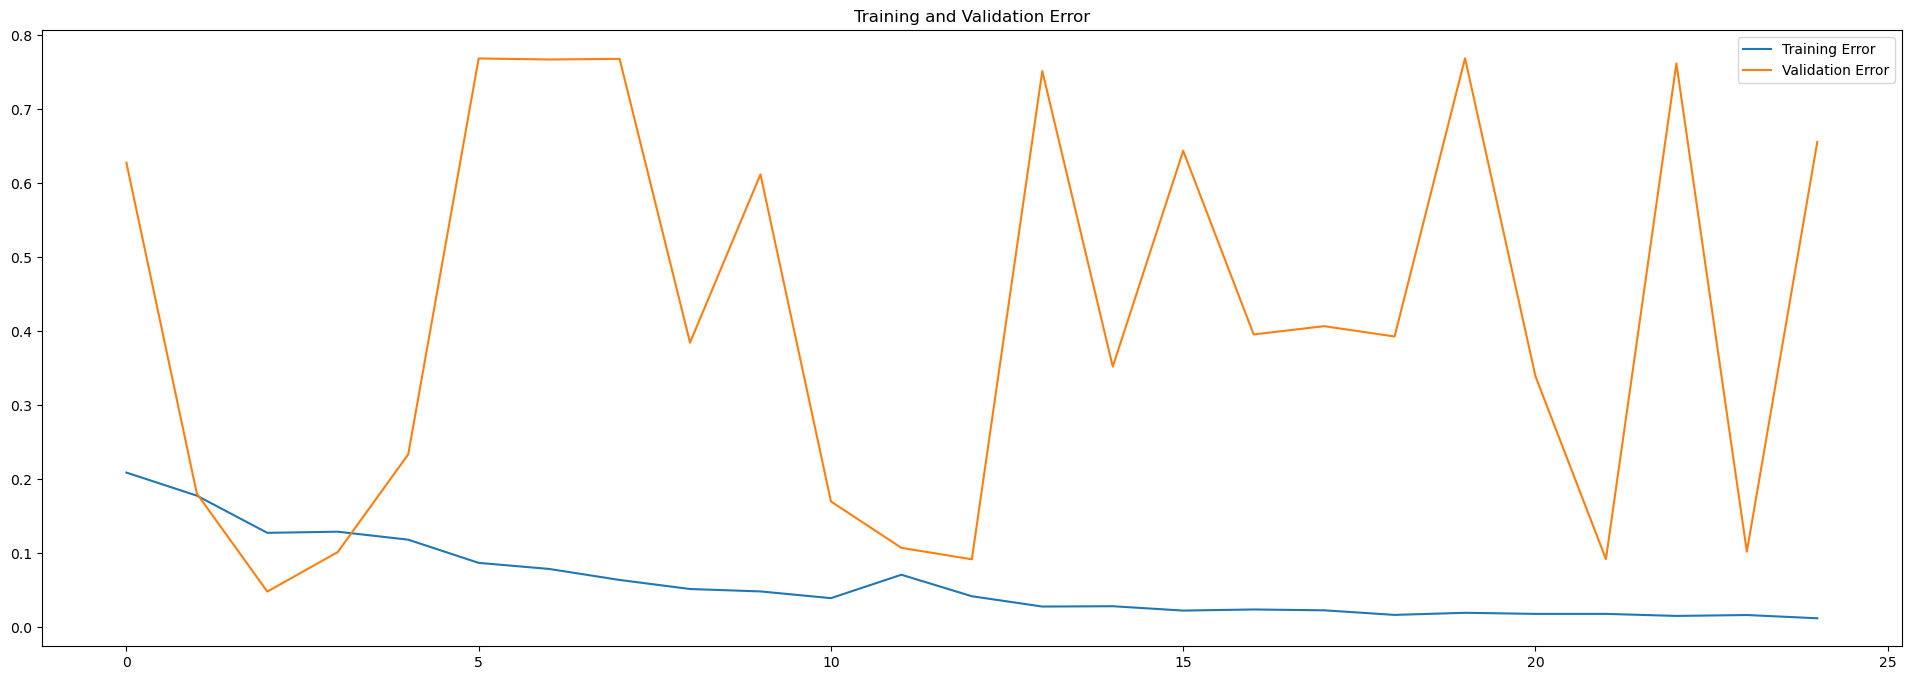

In [16]:
# Concatenate training accuracy from the initial training and augmented training
accuracy = history_augmented_initial_run.history['accuracy'] + history_augmented.history['accuracy']

# Concatenate validation accuracy from the initial training and augmented training
val_accuracy = history_augmented_initial_run.history['val_accuracy'] + history_augmented.history['val_accuracy']

# Create a range of epochs for plotting, taking into account the concatenation of histories
epochs_range = range(epochs + len(history_augmented.history['accuracy']))

# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(24, 8))

# Plot training and validation error over epochs
plt.plot(epochs_range, [1-i for i in accuracy], label='Training Error')
plt.plot(epochs_range, [1-i for i in val_accuracy], label='Validation Error')
plt.legend()
plt.title('Training and Validation Error')

#### (iii) Report Precision, Recall, and F1 score for your model.

In [17]:
# Initialize a list to store actual labels
actual_labels = []

# Iterate through the test dataset to extract true labels
for _, label in tf_dataset_test_onehot:
    # Convert label tensor to NumPy array and iterate through its elements
    for a in label.numpy():
        # Append each true label to the list
        actual_labels.append(a)

In [20]:
# Make predictions on the training, validation, and test sets using the augmented model
training_pred = np.argmax(model_aug.predict(tf_dataset_train_combined), axis=1)
validation_pred = np.argmax(model_aug.predict(tf_dataset_val_onehot), axis=1)
testing_pred = np.argmax(model_aug.predict(tf_dataset_test_onehot), axis=1)

# Extract the actual labels from the one-hot encoded representation
act_labels = np.argmax(actual_labels, axis=1)

# Generate and print the classification report on the test set
report = classification_report(act_labels, testing_pred)
print("Classification Report:\n", report)

# Calculate and print the accuracy on the test set
accuracy = sum(testing_pred == act_labels) / len(testing_pred)
print(f"Accuracy on Test Set: {accuracy}")

249/249 [==============================] - 37s 146ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.50      0.36      2197
           1       0.73      0.51      0.60      5771

    accuracy                           0.50      7968
   macro avg       0.50      0.50      0.48      7968
weighted avg       0.60      0.50      0.53      7968

Accuracy on Test Set: 0.5045180722891566


### (d) Transfer Learning

#### (i)

In [25]:
# Define transfer learning models
def t_learning_model_generator(act_model, num_classes):
    # Create a new Sequential model incorporating the pre-trained model
    model = models.Sequential([
        act_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Freeze pre-trained layers to retain their learned features
    for layer in act_model.layers:
        layer.trainable = False

    return model

def data_change_size(image, target):
    # Resize input image to 299x299 pixels
    image = tf.image.resize(image, [299, 299])
    return image, target

#### (ii)

In [26]:
# Transform training dataset for transfer learning
tf_dataset_train_t_l = tf_dataset_train_combined.unbatch().batch(8).map(data_change_size)

# Transform validation dataset for transfer learning
tf_dataset_val_t_l = tf_dataset_val_onehot.unbatch().batch(8).map(data_change_size)

# Transform test dataset for transfer learning
tf_dataset_test_t_l = tf_dataset_test_onehot.unbatch().batch(8).map(data_change_size)

#### (iii)-(i) Using EfficientNetB0

In [28]:
# Choose the pre-trained model EfficientNetB0
act_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create transfer learning models
tf_learning_model = t_learning_model_generator(act_model, num_classes)

# Compile the transfer learning model
tf_learning_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Define the number of training epochs
epochs = 10

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the transfer learning model with the initial run
history_initial_tf_EfficientNetB0 = tf_learning_model.fit(
    tf_dataset_train_t_l,
    validation_data=tf_dataset_val_t_l,
    epochs=epochs,
    callbacks=[initial_run]
)


# Train the transfer learning model with early stopping
history_early_stopping_tf_EfficientNetB0 = tf_learning_model.fit(
    tf_dataset_train_t_l,
    validation_data=tf_dataset_val_t_l,
    epochs=epochs,
    callbacks=[early_stopping]
)


14:12:12 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/10
3528/3528 [==============================] - 675s 191ms/step - loss: 1.8852 - accuracy: 0.6232 - val_loss: 0.9402 - val_accuracy: 0.7692
Epoch 2/10
3528/3528 [==============================] - 686s 194ms/step - loss: 0.8360 - accuracy: 0.6497 - val_loss: 0.6430 - val_accuracy: 0.7692
Epoch 3/10
3528/3528 [==============================] - 713s 202ms/step - loss: 0.6985 - accuracy: 0.6545 - val_loss: 1.7330 - val_accuracy: 0.2307
Epoch 4/10
3528/3528 [==============================] - 710s 201ms/step - loss: 0.6581 - accuracy: 0.6590 - val_loss: 0.6696 - val_accuracy: 0.7692
Epoch 5/10
3528/3528 [==============================] - 717s 203ms/step - loss: 0.6446 - accuracy: 0.6588 - val_loss: 0.5628 - val_accuracy: 0.7692
Epoch 6/10
3528/3528 [==============================] - 732s 207ms/step - loss: 0.6347 - accuracy: 0.6636 - val_loss: 2.8378 - val_accuracy: 0.2309
Epoch 7/10
3528/3528 [==============================] - 771s 218ms/step - loss: 0.6298 - accuracy: 0.6628 - val_

#### (iii)-(ii) Using ResNet50

In [33]:
# Choose the pre-trained model ResNet50
act_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create transfer learning models
tf_learning_model_ResNet50 = t_learning_model_generator(act_model, num_classes)

# Compile the transfer learning model
tf_learning_model_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Define the number of training epochs
epochs = 10

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the transfer learning model with the initial run
history_initial_tf_ResNet50 = tf_learning_model_ResNet50.fit(
    tf_dataset_train_t_l,
    validation_data=tf_dataset_val_t_l,
    epochs=epochs,
    callbacks=[initial_run]
)


# Train the transfer learning model with early stopping
history_early_stopping_tf_ResNet50 = tf_learning_model_ResNet50.fit(
    tf_dataset_train_t_l,
    validation_data=tf_dataset_val_t_l,
    epochs=epochs,
    callbacks=[early_stopping]
)


94765736/94765736 [==============================] - 3s 0us/step


19:19:10 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/10
3528/3528 [==============================] - 2277s 645ms/step - loss: 0.9093 - accuracy: 0.8334 - val_loss: 2.8146 - val_accuracy: 0.7692
Epoch 2/10
3528/3528 [==============================] - 2336s 662ms/step - loss: 0.4600 - accuracy: 0.8481 - val_loss: 2.6482 - val_accuracy: 0.7693
Epoch 3/10
3528/3528 [==============================] - 2365s 670ms/step - loss: 0.4082 - accuracy: 0.8465 - val_loss: 6.3123 - val_accuracy: 0.2307
Epoch 4/10
3528/3528 [==============================] - 3222s 913ms/step - loss: 0.3854 - accuracy: 0.8496 - val_loss: 1.5616 - val_accuracy: 0.7693
Epoch 5/10
3528/3528 [==============================] - 3130s 887ms/step - loss: 0.3784 - accuracy: 0.8512 - val_loss: 0.9358 - val_accuracy: 0.7692
Epoch 6/10
3528/3528 [==============================] - 2826s 800ms/step - loss: 0.3725 - accuracy: 0.8529 - val_loss: 6.3848 - val_accuracy: 0.2306
Epoch 7/10
3528/3528 [==============================] - 2224s 630ms/step - loss: 0.3696 - accuracy: 0.8513

#### (iii)-(iii) Using VGG16

In [39]:
# Choose the pre-trained model VGG16
act_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create transfer learning models
tf_learning_model_VGG16 = t_learning_model_generator(act_model, num_classes)

# Compile the transfer learning model
tf_learning_model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Define the number of training epochs
epochs = 10

# Train the transfer learning model with the initial run
history_initial_run_tf_VGG16 = tf_learning_model_VGG16.fit(
    tf_dataset_train_t_l,
    validation_data=tf_dataset_val_t_l,
    epochs=epochs,
    callbacks=[initial_run]
)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
3528/3528 [==============================] - 467s 245ms/step - loss: 0.3690 - accuracy: 0.8292 - val_loss: 1.4156 - val_accuracy: 0.4410
Epoch 2/10
3528/3528 [==============================] - 459s 245ms/step - loss: 0.3302 - accuracy: 0.8485 - val_loss: 0.6633 - val_accuracy: 0.6798
Epoch 3/10
3528/3528 [==============================] - 460s 246ms/step - loss: 0.3239 - accuracy: 0.8543 - val_loss: 1.0421 - val_accuracy: 0.5745
Epoch 4/10
3528/3528 [==============================] - 458s 245ms/step - loss: 0.3159 - accuracy: 0.8569 - val_loss: 0.8653 - val_accuracy: 0.6066
Epoch 5/10
3528/3528 [==============================] - 460s 246ms/step - loss: 0.3116 - accuracy: 0.8603 - val_loss: 0.4544 - val_accuracy: 0.7954
Epoch 6/10
3528/3528 [==============================] - 460s 246ms/step - loss: 0.3096 - accuracy: 0.8612 - val_loss: 0.6389 - val_accuracy: 0.7021
Epoch 7/10
3528/3528 [========================

In [37]:
# Choose the pre-trained model VGG16
act_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create transfer learning models
tf_learning_model_VGG16 = t_learning_model_generator(act_model, num_classes)

# Compile the transfer learning model
tf_learning_model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Define the number of training epochs
epochs = 10

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the transfer learning model with the initial run
history_early_stopping_tf_VGG16 = tf_learning_model_VGG16.fit(
    tf_dataset_train_t_l,
    validation_data=tf_dataset_val_t_l,
    epochs=epochs,
    callbacks=[early_stopping]
)

58889256/58889256 [==============================] - 2s 0us/step


07:51:07 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/10
3528/3528 [==============================] - 6536s 2s/step - loss: 0.9333 - accuracy: 0.9250 - val_loss: 4.3534 - val_accuracy: 0.2818
Epoch 2/10
3528/3528 [==============================] - 6679s 2s/step - loss: 0.3294 - accuracy: 0.9467 - val_loss: 4.5405 - val_accuracy: 0.2661


#### (iv)-(i) Using EfficientNetB0

Text(0.5, 1.0, 'Training and Validation Error')

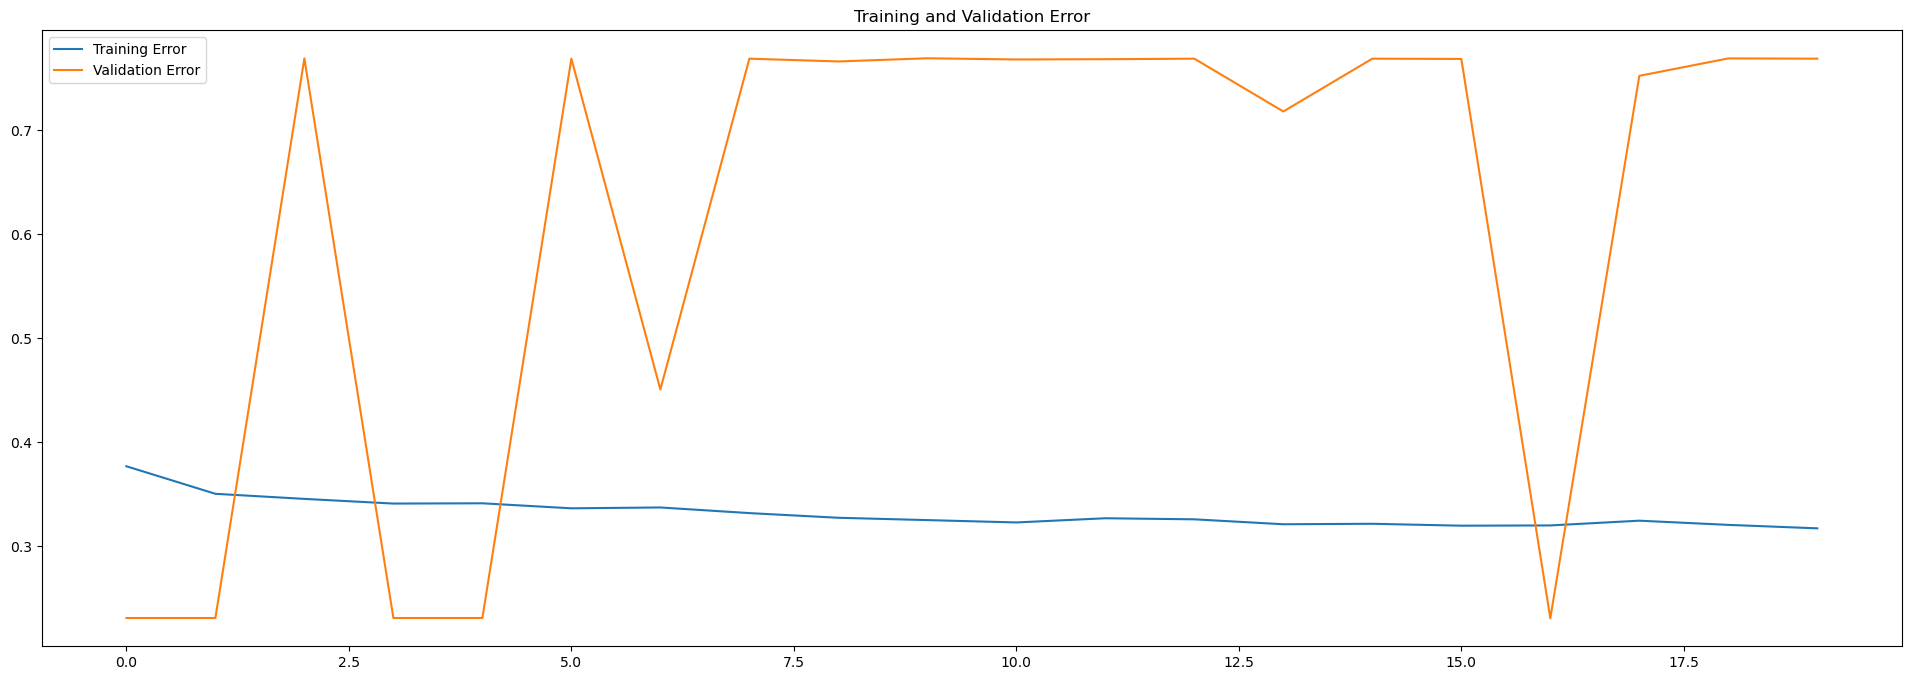

In [40]:
# Concatenate training accuracy from the initial training and augmented training
accuracy = history_initial_tf_EfficientNetB0.history['accuracy'] + history_early_stopping_tf_EfficientNetB0.history['accuracy']

# Concatenate validation accuracy from the initial training and augmented training
val_accuracy = history_initial_tf_EfficientNetB0.history['val_accuracy'] + history_early_stopping_tf_EfficientNetB0.history['val_accuracy']

# Create a range of epochs for plotting, taking into account the concatenation of histories
epochs_range = range(epochs + len(history_early_stopping_tf_EfficientNetB0.history['accuracy']))

# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(24, 8))

# Plot training and validation error over epochs
plt.plot(epochs_range, [1-i for i in accuracy], label='Training Error')
plt.plot(epochs_range, [1-i for i in val_accuracy], label='Validation Error')
plt.legend()
plt.title('Training and Validation Error')

#### (iv)-(ii) Using ResNet50

Text(0.5, 1.0, 'Training and Validation Error')

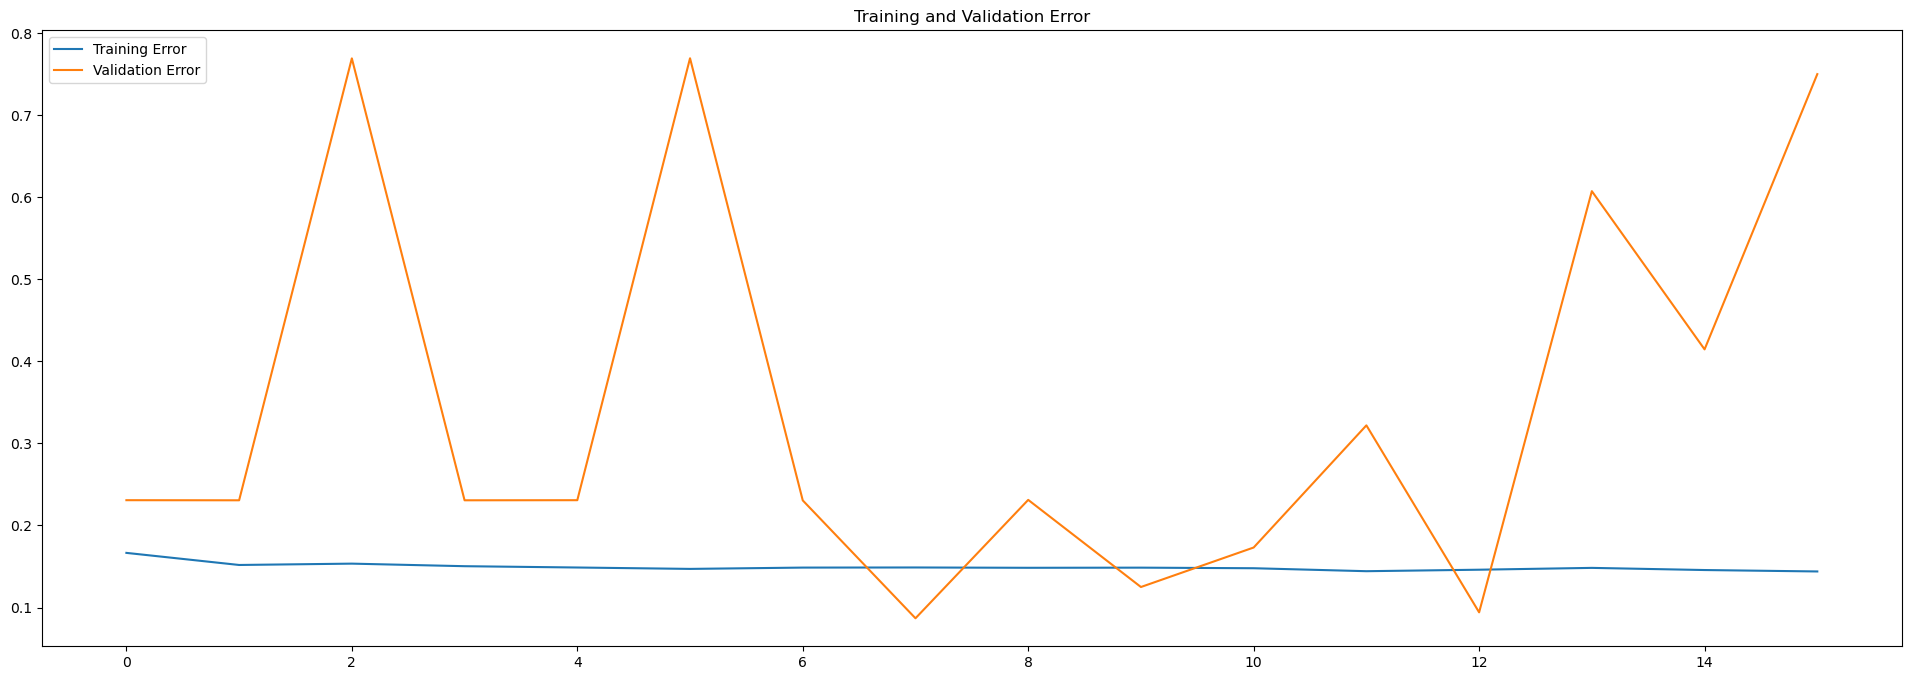

In [41]:
# Concatenate training accuracy from the initial training and augmented training
accuracy = history_initial_tf_ResNet50.history['accuracy'] + history_early_stopping_tf_ResNet50.history['accuracy']

# Concatenate validation accuracy from the initial training and augmented training
val_accuracy = history_initial_tf_ResNet50.history['val_accuracy'] + history_early_stopping_tf_ResNet50.history['val_accuracy']

# Create a range of epochs for plotting, taking into account the concatenation of histories
epochs_range = range(epochs + len(history_early_stopping_tf_ResNet50.history['accuracy']))

# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(24, 8))

# Plot training and validation error over epochs
plt.plot(epochs_range, [1-i for i in accuracy], label='Training Error')
plt.plot(epochs_range, [1-i for i in val_accuracy], label='Validation Error')
plt.legend()
plt.title('Training and Validation Error')

#### (iv)-(iii) Using VGG16

Text(0.5, 1.0, 'Training and Validation Error')

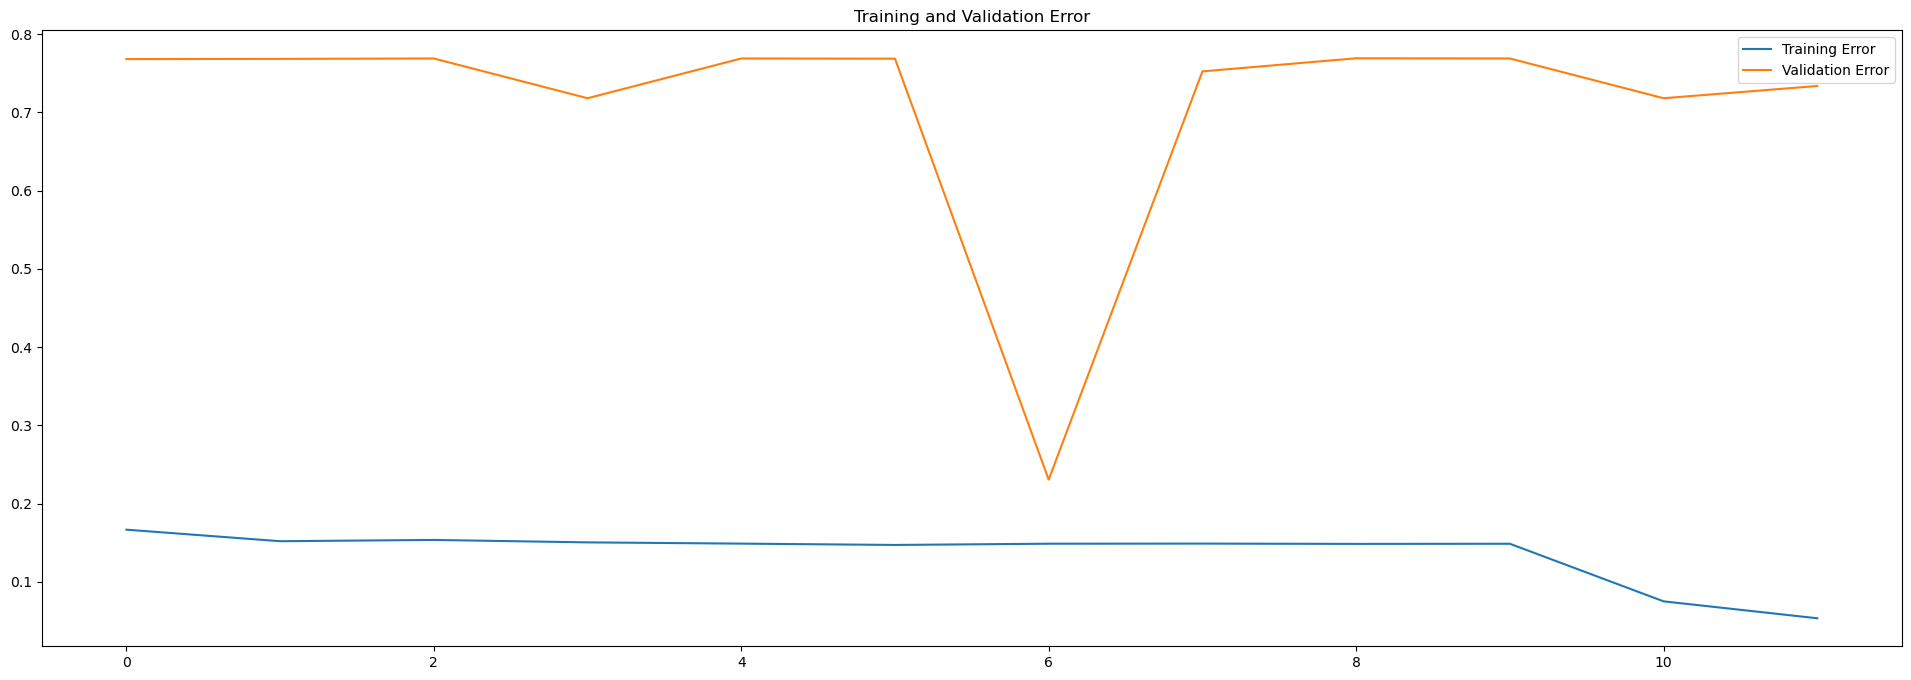

In [42]:
# Concatenate training accuracy from the initial training and augmented training
accuracy = history_initial_run_tf_VGG16.history['accuracy'] + history_early_stopping_tf_VGG16.history['accuracy']

# Concatenate validation accuracy from the initial training and augmented training
val_accuracy = history_initial_run_tf_VGG16.history['val_accuracy'] + history_early_stopping_tf_VGG16.history['val_accuracy']

# Create a range of epochs for plotting, taking into account the concatenation of histories
epochs_range = range(epochs + len(history_early_stopping_tf_VGG16.history['accuracy']))

# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(24, 8))

# Plot training and validation error over epochs
plt.plot(epochs_range, [1-i for i in accuracy], label='Training Error')
plt.plot(epochs_range, [1-i for i in val_accuracy], label='Validation Error')
plt.legend()
plt.title('Training and Validation Error')

#### (v)-(i) Using EfficientNetB0

In [30]:
# Initialize a list to store actual labels
actual_labels = []

# Iterate through the test dataset to extract true labels
for _, label in tf_dataset_test_onehot:
    # Convert label tensor to NumPy array and iterate through its elements
    for a in label.numpy():
        # Append each true label to the list
        actual_labels.append(a)

In [32]:
# Make predictions on the training, validation, and test sets using the augmented model
training_pred = np.argmax(tf_learning_model.predict(tf_dataset_train_t_l), axis=1)
validation_pred = np.argmax(tf_learning_model.predict(tf_dataset_val_t_l), axis=1)
testing_pred = np.argmax(tf_learning_model.predict(tf_dataset_test_t_l), axis=1)

# Extract the actual labels from the one-hot encoded representation
act_labels = np.argmax(actual_labels, axis=1)

# Generate and print the classification report on the test set
report = classification_report(act_labels, testing_pred)
print("Classification Report:\n", report)

# Calculate and print the accuracy on the test set
accuracy = sum(testing_pred == act_labels) / len(testing_pred)
print(f"Accuracy on Test Set: {accuracy}")

996/996 [==============================] - 164s 165ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.01      0.01      2196
           1       0.73      1.00      0.84      5772

    accuracy                           0.72      7968
   macro avg       0.59      0.50      0.43      7968
weighted avg       0.65      0.72      0.61      7968

Accuracy on Test Set: 0.7240210843373494


#### (v)-(ii) Using ResNet50

In [35]:
# Initialize a list to store actual labels
actual_labels = []

# Iterate through the test dataset to extract true labels
for _, label in tf_dataset_test_onehot:
    # Convert label tensor to NumPy array and iterate through its elements
    for a in label.numpy():
        # Append each true label to the list
        actual_labels.append(a)

In [36]:
# Make predictions on the training, validation, and test sets using the augmented model
training_pred = np.argmax(tf_learning_model_ResNet50.predict(tf_dataset_train_t_l), axis=1)
validation_pred = np.argmax(tf_learning_model_ResNet50.predict(tf_dataset_val_t_l), axis=1)
testing_pred = np.argmax(tf_learning_model_ResNet50.predict(tf_dataset_test_t_l), axis=1)

# Extract the actual labels from the one-hot encoded representation
act_labels = np.argmax(actual_labels, axis=1)

# Generate and print the classification report on the test set
report = classification_report(act_labels, testing_pred)
print("Classification Report:\n", report)

# Calculate and print the accuracy on the test set
accuracy = sum(testing_pred == act_labels) / len(testing_pred)
print(f"Accuracy on Test Set: {accuracy}")

996/996 [==============================] - 531s 533ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.70      0.39      2196
           1       0.72      0.28      0.41      5772

    accuracy                           0.40      7968
   macro avg       0.49      0.49      0.40      7968
weighted avg       0.59      0.40      0.40      7968

Accuracy on Test Set: 0.39959839357429716


#### (v)-(iii) Using VGG16

In [43]:
# Initialize a list to store actual labels
actual_labels = []

# Iterate through the test dataset to extract true labels
for _, label in tf_dataset_test_onehot:
    # Convert label tensor to NumPy array and iterate through its elements
    for a in label.numpy():
        # Append each true label to the list
        actual_labels.append(a)

In [44]:
# Make predictions on the training, validation, and test sets using the augmented model
training_pred = np.argmax(tf_learning_model_VGG16.predict(tf_dataset_train_t_l), axis=1)
validation_pred = np.argmax(tf_learning_model_VGG16.predict(tf_dataset_val_t_l), axis=1)
testing_pred = np.argmax(tf_learning_model_VGG16.predict(tf_dataset_test_t_l), axis=1)

# Extract the actual labels from the one-hot encoded representation
act_labels = np.argmax(actual_labels, axis=1)

# Generate and print the classification report on the test set
report = classification_report(act_labels, testing_pred)
print("Classification Report:\n", report)

# Calculate and print the accuracy on the test set
accuracy = sum(testing_pred == act_labels) / len(testing_pred)
print(f"Accuracy on Test Set: {accuracy}")

996/996 [==============================] - 1470s 1s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.09      0.14      2197
           1       0.73      0.93      0.82      5771

    accuracy                           0.70      7968
   macro avg       0.52      0.51      0.48      7968
weighted avg       0.61      0.70      0.63      7968

Accuracy on Test Set: 0.6960341365461847


#### (vi)

The accuracy of the models that were built in this exercise are as follows:

1. CNN + MLP --> 50.4%
2. Transfer Learning(EfficientNetB0) --> 72.4%
3. Transfer Learning(ResNet50) --> 39.9%
4. Transfer Learning(VGG16) --> 69.6%

Transfer Learning models is comparitively better than the CNN + MLP models. We have better control over the CNN + MLP models as we can define their architecture from scratch, but the Transfer learning models are already pre-trained on large image datasets.

Also, the time taken for training for of the Transfer learning models is lesser compared to that of the CNN + MLP models, because they are already pre-trained.

Among all the above models, the Transfer Learning(EfficientNetB0) model has better accuracy and also the training time.